In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)

In [3]:
df = pd.DataFrame(data=y,index=x,columns=['Sinus'])
df

,Sinus
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


## Répartition Train / Test


Note ! C'est très différent de notre méthodologie habituelle de répartition Entraînement / Test !

In [4]:
len(df)

501

In [5]:
test_percent = 0.1

In [6]:
len(df)*test_percent

50.1

In [7]:
test_point = np.round(len(df)*test_percent) #point coupure

In [90]:
test_point

50.0

In [8]:
test_ind = int(len(df) - test_point)

In [92]:
test_ind

451

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Mise à l'échelle des données

> Bloc en retrait

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [13]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Phase entrainement

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# définir un générateur
length = 25 # Longueur des séquences de sortie (en nombre de pas temporel)
batch_size = 1 # Nombre d'échantillons de séries temporelles dans chaque batch (lot)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)#scaled_train contient les données x et y

In [16]:
len(scaled_train)

451

In [17]:
len(generator) #cet objet generator va generer des batchs de données pour nous
# est scalé train soustrait de la longueur de la séquence

426

In [18]:
# À quoi ressemble le premier batch ?
X,y = generator[0] #premier batch de données

In [19]:
X

array([[[0.49999912],
        [0.54991622],
        [0.59933458],
        [0.64776041],
        [0.69470985],
        [0.73971381],
        [0.78232262],
        [0.82211054],
        [0.85868004],
        [0.89166571],
        [0.92073798],
        [0.94560637],
        [0.9660224 ],
        [0.98178208],
        [0.99272794],
        [0.99875061],
        [0.99978993],
        [0.9958355 ],
        [0.98692684],
        [0.97315296],
        [0.95465148],
        [0.93160726],
        [0.90425056],
        [0.87285471],
        [0.83773342]]])

In [20]:
y

array([[0.79923759]])

In [21]:
print(f"Compte tenu du tableau suivant : \n{X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
[0.49999912 0.54991622 0.59933458 0.64776041 0.69470985 0.73971381
 0.78232262 0.82211054 0.85868004 0.89166571 0.92073798 0.94560637
 0.9660224  0.98178208 0.99272794 0.99875061 0.99978993 0.9958355
 0.98692684 0.97315296 0.95465148 0.93160726 0.90425056 0.87285471
 0.83773342]
Cela prédit ce y : 
 [[0.79923759]]


<Axes: >

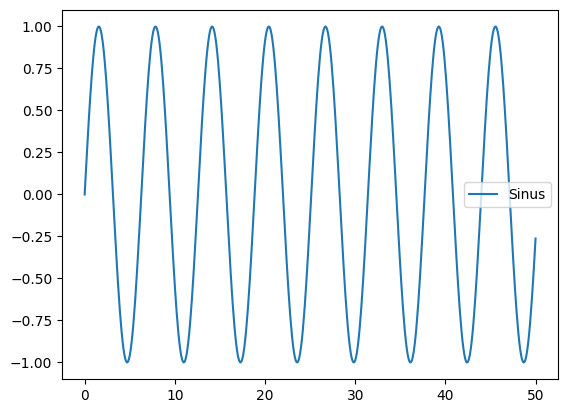

In [22]:
df.plot()

In [23]:
# Redéfinissons pour obtenir 10 pas en arrière et prédisons ensuite le prochain pas en avant
length = 50 # Longueur des séquences de sortie (en nombre de pas temporel)
batch_size = 1 # Le batch_size fait référence au nombre d'exemples de données inclus dans chaque lot d'entraînement.
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)#scaled_train contient les données x et y

Vous allez maintenant pouvoir modifier la longueur de manière à ce qu'elle ait un sens pour votre série temporelle !

```
# This is formatted as code
```

## Créer le modèle

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [25]:
n_features = 1

In [26]:
# définir le modèle
model = Sequential()

# Couche simple RNN
model.add(SimpleRNN(50,input_shape=(length,n_features))) #50 neurones

# Prédiction finale
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [28]:
# ajustement du modèle
model.fit(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 2s 4ms/step - loss: 0.0110
Epoch 2/5
401/401 [==============================] - 2s 4ms/step - loss: 5.8108e-05
Epoch 3/5
401/401 [==============================] - 2s 4ms/step - loss: 3.6696e-05
Epoch 4/5
401/401 [==============================] - 1s 4ms/step - loss: 2.3217e-04
Epoch 5/5
401/401 [==============================] - 1s 3ms/step - loss: 2.9953e-04


In [29]:
losses = pd.DataFrame(model.history.history) 
#on peut voir que l'erreur diminue au fur et à mesure des epochs

In [30]:
losses

,loss
0,0.010996
1,0.000058
2,0.000037
3,0.000232
4,0.000300


<Axes: >

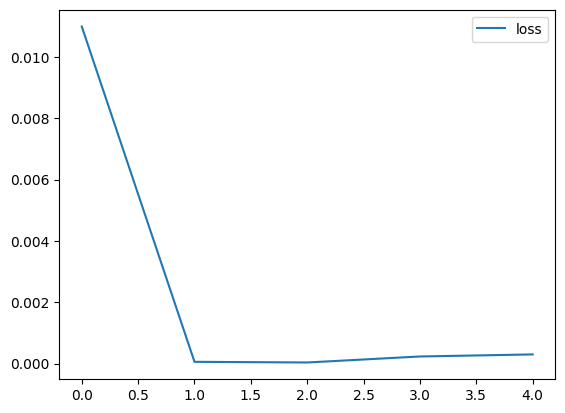

In [31]:
losses.plot() #nous evaluons nos pertes

## Évaluer sur les données de test

> Indented block

In [32]:
# Pensons au premier point batch que je devrai passer dans mon modèle pour prédire quelque chose sur le set de test

first_eval_batch = scaled_train[-length:] #on prend les 50 derniers points de train pour predire le premier point de test

In [33]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) #on reshape pour que le modèle puisse le lire

In [34]:
model.predict(first_eval_batch) #on predit le premier point de test

1/1 [==============================] - 0s 104ms/step


array([[0.9485281]], dtype=float32)

In [35]:
scaled_test[0] #on compare avec le premier point de test

array([0.94955134])

Mettons maintenant cette logique dans une boucle for pour prédire l'avenir pour toute la gamme de test.

In [36]:
#boucle pour predire tous les points de test
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))


In [37]:
first_eval_batch

array([[8.37405820e-01],
       [7.98881698e-01],
       [7.57371240e-01],
       [7.13289205e-01],
       [6.67076045e-01],
       [6.19193508e-01],
       [5.70120021e-01],
       [5.20345908e-01],
       [4.70368497e-01],
       [4.20687145e-01],
       [3.71798252e-01],
       [3.24190300e-01],
       [2.78338972e-01],
       [2.34702398e-01],
       [1.93716581e-01],
       [1.55791039e-01],
       [1.21304709e-01],
       [9.06021693e-02],
       [6.39901882e-02],
       [4.17346643e-02],
       [2.40579672e-02],
       [1.11367167e-02],
       [3.10001778e-03],
       [2.81703720e-05],
       [1.95186738e-03],
       [8.85188786e-03],
       [2.06592891e-02],
       [3.72560954e-02],
       [5.84764771e-02],
       [8.41084070e-02],
       [1.13895779e-01],
       [1.47540969e-01],
       [1.84707803e-01],
       [2.25024924e-01],
       [2.68089497e-01],
       [3.13471233e-01],
       [3.60716695e-01],
       [4.09353821e-01],
       [4.58896644e-01],
       [5.08850150e-01],


In [38]:
predicted_value = [[[99]]] #on initialise predicted_value
np.append(current_batch[:,1:,:],[[[99]]],axis=1) #on prend le dernier point de current_batch et on lui ajoute le point suivant de scaled_train

array([[[7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.58896644e-01],
        [5.0

In [39]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [40]:
test_predictions

[array([0.9485281], dtype=float32),
 array([0.96684444], dtype=float32),
 array([0.9803084], dtype=float32),
 array([0.9890001], dtype=float32),
 array([0.99269754], dtype=float32),
 array([0.99158555], dtype=float32),
 array([0.98580116], dtype=float32),
 array([0.97544795], dtype=float32),
 array([0.9606165], dtype=float32),
 array([0.94131994], dtype=float32),
 array([0.9176646], dtype=float32),
 array([0.8898815], dtype=float32),
 array([0.8579852], dtype=float32),
 array([0.82224244], dtype=float32),
 array([0.78298134], dtype=float32),
 array([0.7405842], dtype=float32),
 array([0.69545144], dtype=float32),
 array([0.64793867], dtype=float32),
 array([0.59844065], dtype=float32),
 array([0.54733396], dtype=float32),
 array([0.49512932], dtype=float32),
 array([0.44237143], dtype=float32),
 array([0.38964477], dtype=float32),
 array([0.33755568], dtype=float32),
 array([0.28671882], dtype=float32),
 array([0.23784421], dtype=float32),
 array([0.19153185], dtype=float32),
 array([0

In [41]:
scaled_test

array([[9.49551344e-01],
       [9.69156618e-01],
       [9.84074225e-01],
       [9.94155114e-01],
       [9.99298559e-01],
       [9.99453170e-01],
       [9.94617400e-01],
       [9.84839568e-01],
       [9.70217371e-01],
       [9.50896908e-01],
       [9.27071224e-01],
       [8.98978376e-01],
       [8.66899060e-01],
       [8.31153800e-01],
       [7.92099752e-01],
       [7.50127132e-01],
       [7.05655314e-01],
       [6.59128649e-01],
       [6.11012013e-01],
       [5.61786173e-01],
       [5.11942978e-01],
       [4.61980443e-01],
       [4.12397778e-01],
       [3.63690397e-01],
       [3.16344967e-01],
       [2.70834550e-01],
       [2.27613868e-01],
       [1.87114770e-01],
       [1.49741909e-01],
       [1.15868702e-01],
       [8.58335998e-02],
       [5.99367021e-02],
       [3.84367625e-02],
       [2.15486014e-02],
       [9.44095974e-03],
       [2.23481297e-03],
       [2.16257798e-06],
       [2.76531647e-03],
       [1.04966661e-02],
       [2.31189624e-02],


## Transformations inverses et Comparaison

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

In [43]:
true_predictions

array([[ 0.89705079],
       [ 0.93368315],
       [ 0.96061089],
       [ 0.97799408],
       [ 0.98538893],
       [ 0.98316498],
       [ 0.97159629],
       [ 0.95089004],
       [ 0.92122743],
       [ 0.88263457],
       [ 0.83532424],
       [ 0.77975849],
       [ 0.71596642],
       [ 0.64448147],
       [ 0.5659599 ],
       [ 0.4811663 ],
       [ 0.39090151],
       [ 0.29587673],
       [ 0.19688148],
       [ 0.09466892],
       [-0.00973952],
       [-0.11525445],
       [-0.22070692],
       [-0.32488427],
       [-0.42655718],
       [-0.5243056 ],
       [-0.61692958],
       [-0.70338545],
       [-0.78265109],
       [-0.85386712],
       [-0.91620922],
       [-0.96933918],
       [-1.01260236],
       [-1.04554144],
       [-1.06759982],
       [-1.07851674],
       [-1.07822408],
       [-1.0664022 ],
       [-1.04327008],
       [-1.00887399],
       [-0.96360632],
       [-0.9078734 ],
       [-0.84226922],
       [-0.7677533 ],
       [-0.68514362],
       [-0

In [44]:
test['Predictions'] = true_predictions

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13200\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [45]:
test

,Sinus,Predictions
45.1,0.899097,0.897051
45.2,0.938307,0.933683
45.3,0.968142,0.960611
45.4,0.988304,0.977994
45.5,0.998591,0.985389
45.6,0.998900,0.983165
45.7,0.989229,0.971596
45.8,0.969673,0.950890
45.9,0.940429,0.921227
46.0,0.901788,0.882635


<Axes: >

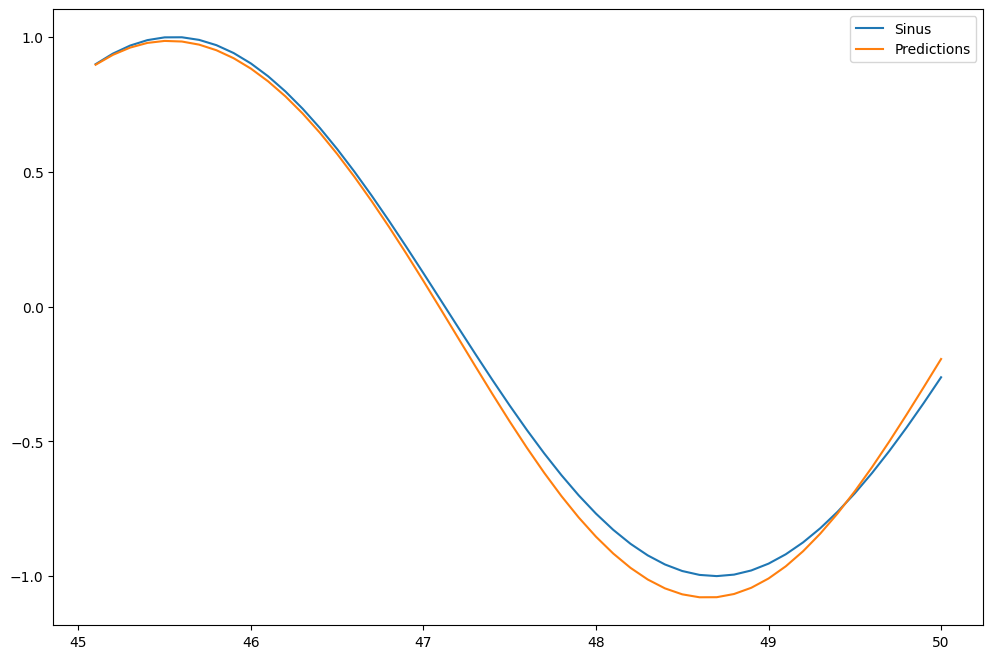

In [46]:
test.plot(figsize=(12,8))